# Example Code for using meshpy

In [ ]:
from meshpy import triangle, geometry
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.mesher import *
from src.environment import *
from src.dynamics import *
from src.refiner import MeshRefiner
from tqdm import tqdm

## Building Geometry

In [2]:
builder = geometry.GeometryBuilder()

Add Circle

In [3]:
# points,facets,_,facet_markers = geometry.make_circle(.5,(0.0,0.0),marker = 1)
# builder.add_geometry(points,facets,facet_markers=facet_markers)

Add Box

In [4]:
points,facets,_,_ = geometry.make_box((0, 0), (2.0, 2.0),subdivisions=(200, 200))
builder.add_geometry(points,facets, facet_markers=1)

## Setting Mesh Info

In [5]:
info = triangle.MeshInfo()
builder.set(info)
#info.set_holes([(0.0, 0.0)]) # Sets center circle as a hole

In [6]:
points = np.asarray([[.005,.005],[.005,1.995],[1.995,.005],[1.995,1.995]])
points = np.vstack([np.array(info.points),points])

In [7]:
info.set_points(points)

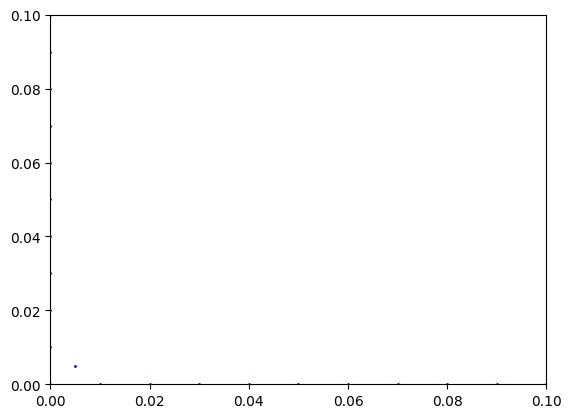

In [8]:
points = np.array(info.points)
plt.scatter(points[...,0], points[...,1], s=1, c='blue', label='Mesh Points')
plt.axis([0,.1,0,.1])
plt.show()

Meshing

In [9]:
# def triangle_skewness(verts):
#     # verts: list of 3 meshpy Point objects, each with .x and .y
#     p = np.array([[v.x, v.y] for v in verts])
#     v = [p[(i+1)%3] - p[i] for i in range(3)]
#     angles = []
#     for i in range(3):
#         a = v[i-1]
#         b = -v[i]
#         cos_theta = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
#         angle = np.arccos(np.clip(cos_theta, -1, 1)) * 180 / np.pi
#         angles.append(angle)
#     return max(abs(angle - 60) for angle in angles)

# def needs_refinement(vertices, area, skew_thresh=30.0):
#     # vertices: list of meshpy Point objects
#     skew = triangle_skewness(vertices)
#     return skew > skew_thresh

# mesh = triangle.build(
#     info,
#     refinement_func=lambda verts, area: needs_refinement(verts, area, skew_thresh=40.0),
#     min_angle=30.0,
#     max_volume=0.0005,
#     generate_faces=True,
#     generate_neighbor_lists=True,
#     attributes=True,
#     volume_constraints=True
# )

In [10]:
mesh = triangle.build(info,min_angle=33.0,
                      max_volume=.001,
                      generate_faces=True,
                      generate_neighbor_lists=True,
                      attributes=True,
                      volume_constraints=True)

In [11]:
np.array(mesh.elements).shape

(10824, 3)

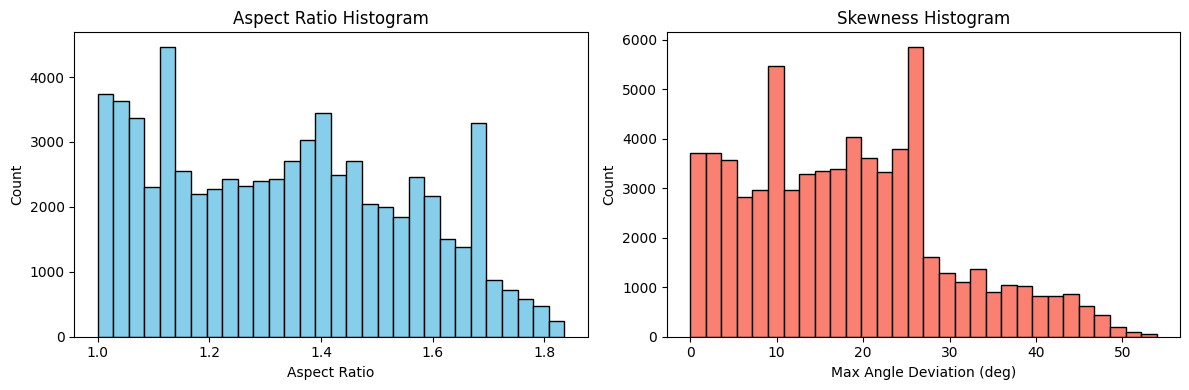

Number of cells with aspect ratio > 3.0: 0
Number of cells with skewness > 30.0°: 9763
Maximum skewness: 53.97
Iteration 0: 9763 bad triangles, max skewness: 53.97, elements: 68120
Iteration 1: 2038 bad triangles, max skewness: 53.92, elements: 68418
Iteration 2: 1072 bad triangles, max skewness: 53.55, elements: 68466
Iteration 3: 894 bad triangles, max skewness: 50.56, elements: 68484
Iteration 4: 858 bad triangles, max skewness: 45.55, elements: 68484
Global remeshing performed at iteration 5
Iteration 5: 970 bad triangles, max skewness: 50.17, elements: 69534
Iteration 6: 907 bad triangles, max skewness: 51.16, elements: 69546
Iteration 7: 877 bad triangles, max skewness: 54.43, elements: 69552
Iteration 8: 880 bad triangles, max skewness: 50.62, elements: 69566
Iteration 9: 908 bad triangles, max skewness: 48.26, elements: 69654
Global remeshing performed at iteration 10
Iteration 10: 945 bad triangles, max skewness: 54.95, elements: 70032
Iteration 11: 928 bad triangles, max skew

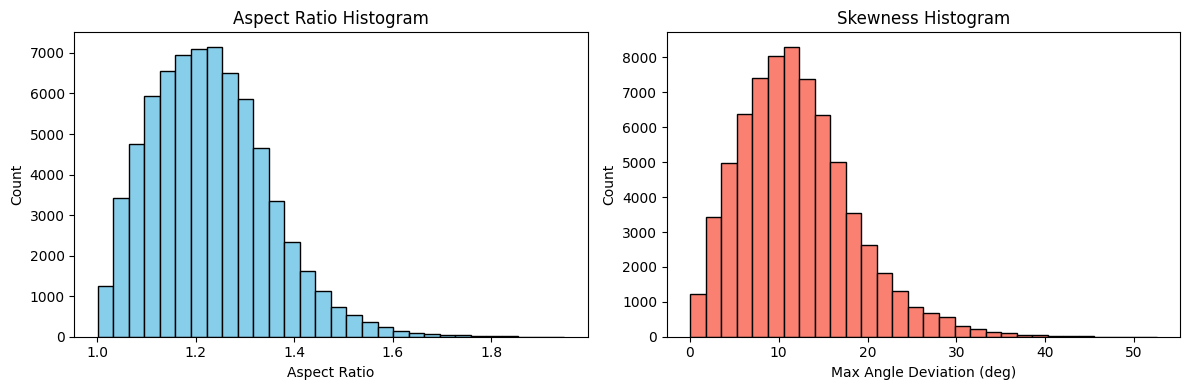

Number of cells with aspect ratio > 3.0: 0
Number of cells with skewness > 30.0°: 839
Maximum skewness: 52.55


In [ ]:
improver = MeshRefiner(mesh)
improver.show_mesh_quality()
mesh = improver.improve(aspect_thresh=3.0,
                        skew_thresh=30.0,
                        max_volume=0.0001,
                        move_fraction=0.1,
                        max_iter=20)
improver.show_mesh_quality()

In [13]:
# mesh = improver.coarsen_mesh(min_edge_length=.005)
# improver.show_mesh_quality()

## Plotting

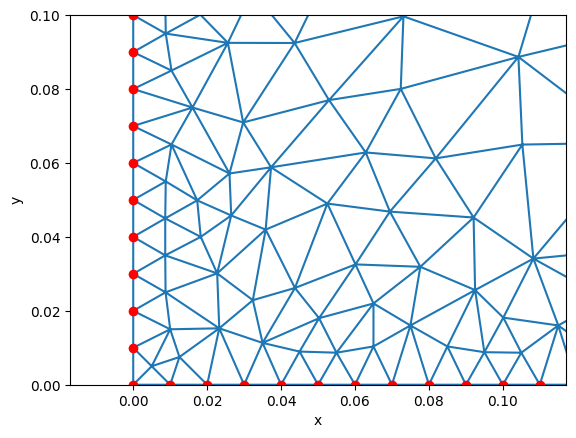

In [12]:
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_attr = np.array(mesh.point_markers)

import matplotlib.pyplot as plt

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.xlabel("x")
plt.ylabel("y")
#
n = np.size(mesh_attr)
inner_nodes = [i for i in range(n) if mesh_attr[i] == 1]
outer_nodes = [i for i in range(n) if mesh_attr[i] == 3]
plt.plot(mesh_points[inner_nodes, 0], mesh_points[inner_nodes, 1], "ro")
plt.plot(mesh_points[outer_nodes, 0], mesh_points[outer_nodes, 1], "go")
plt.axis("equal")
plt.axis([0,.1,0,.1])
plt.show()

In [ ]:
import sys
sys.path.append('..')
from src.mesher import *
from src.environment import *
from src.dynamics import *
mesher = Mesher()
mesher.import_meshpy(mesh)

In [14]:
mesher.calc_mesh_properties()

Calculating cell centers...
Cell centers calculated.
Calculating face centers...
Face centers calculated.
Calculating face normals...
Face normals calculated.
Calculating face lengths...
Face lengths calculated.
Calculating cell face indices and normals...
Cell face indices and normals calculated.
Calculating cell face normal signs...
Cell face normal signs calculated.
Calculating face cell indices...
Face cell indices calculated.
Calculating face ghost distances...
Face ghost distances calculated.
Calculating point cell indices and distances...
Point cell indices and distances calculated.


In [15]:
mesher.verify_stencil_geometry()

Mean angle (deg): 9.69, max: 39.27
Faces with angle > 30 deg: 127
Mean distance error: 0.0000, max: 0.0000
Faces with distance error > 1e-2: 0
Mean face center offset: 1.9550e-03, max: 8.7750e-03


Diagonal node index: 800, coordinates: [0.005 0.005]
Cell indices on diagonal node 800: [1, 2, 198, 395, 397]
Face 0: Center=[0.    0.005], Normal=[-1.  0.], Distances=[0.00166667 0.00166667], Point Plus=[-0.00166667  0.005     ], Point Minus=[0.00166667 0.005     ]
Face 1: Center=[0.0025 0.0025], Normal=[-0.70710677  0.70710677], Distances=[0.00235702 0.00235702], Point Plus=[0.00083333 0.00416667], Point Minus=[0.00416667 0.00083333]
Face 2: Center=[0.0025 0.0075], Normal=[-0.70710677 -0.70710677], Distances=[0.00353553 0.00235702], Point Plus=[0.00083333 0.00583333], Point Minus=[0.005 0.01 ]
Face 0: Center=[0.0025 0.0075], Normal=[-0.70710677 -0.70710677], Distances=[0.00353553 0.00235702], Point Plus=[0.00083333 0.00583333], Point Minus=[0.005 0.01 ]
Face 1: Center=[0.0075 0.01  ], Normal=[-0.89442724  0.44721362], Distances=[0.00186339 0.00223607], Point Plus=[0.0055 0.011 ], Point Minus=[0.00916667 0.00916667]
Face 2: Center=[0.005  0.0125], Normal=[ 0.44721362 -0.89442724], Dis

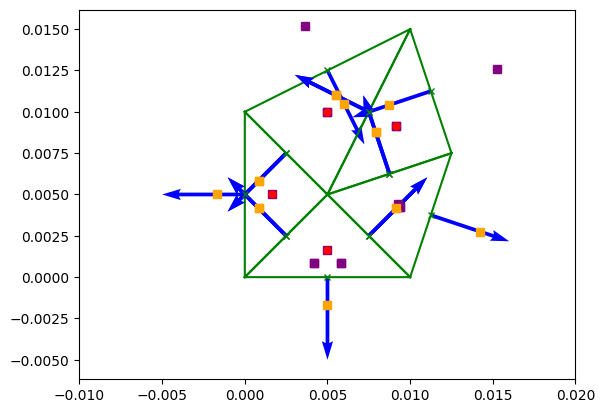

In [15]:
xy = np.asarray(mesher.points)
x = xy[:,0]
y = xy[:,1]
tri = np.asarray(mesher.cells)

# Find the node at (0, 0)
corner_node = np.where((mesher.points[:, 0] == 0) & (mesher.points[:, 1] == 0))[0][0]
corner_coords = mesher.points[corner_node]
# Find all nodes with both coordinates greater than corner_coords
candidates = np.where((mesher.points[:, 0] > corner_coords[0]) & (mesher.points[:, 1] > corner_coords[1]))[0]
if len(candidates) > 0:
    # Find the candidate with minimal distance to (0,0)
    dists = np.linalg.norm(mesher.points[candidates] - corner_coords, axis=1)
    diagonal_node = candidates[np.argmin(dists)]
    print(f"Diagonal node index: {diagonal_node}, coordinates: {mesher.points[diagonal_node]}")
else:
    print("No diagonal node found.")
    diagonal_node = None

if diagonal_node is not None:
    # Find all cells that include the diagonal node
    cells_on_diagonal_node = [i for i, cell in enumerate(mesher.cells) if diagonal_node in cell]
    print(f"Cell indices on diagonal node {diagonal_node}: {cells_on_diagonal_node}")
else:
    cells_on_diagonal_node = []

for cell_index in cells_on_diagonal_node:
    face_centers = mesher.face_centers[mesher.cell_face_indices[cell_index]]
    normals = mesher.face_normals[mesher.cell_face_indices[cell_index]]
    for i, (fc, nrm, dist) in enumerate(zip(face_centers, normals, mesher.face_cell_center_distances[mesher.cell_face_indices[cell_index]])):
        # Now, normal always points outward from the cell
        pt_plus = fc + nrm * dist[1]  # outward from cell center to face
        pt_minus = fc - nrm * dist[0] # inward toward cell center
        print(f"Face {i}: Center={fc}, Normal={nrm}, Distances={dist}, Point Plus={pt_plus}, Point Minus={pt_minus}")
        plt.plot([pt_plus[0]], [pt_plus[1]], marker='s', color='orange', markersize=6, label='Outward Normal' if i == 0 else "")
        plt.plot([pt_minus[0]], [pt_minus[1]], marker='s', color='purple', markersize=6, label='Inward Normal' if i == 0 else "")

    plt.triplot(x, y, tri[cell_index:cell_index + 1], color="g")
    plt.plot(mesher.cell_centers[cell_index, 0], mesher.cell_centers[cell_index, 1], marker='o', color='red', markersize=5, label='Cell Center')
    plt.plot(face_centers[:, 0], face_centers[:, 1], marker='x', color='green', markersize=5, label='Face Center', linestyle='None')
    plt.quiver(face_centers[:, 0], face_centers[:, 1], normals[:, 0], normals[:, 1], color='blue', angles='xy', scale_units='xy', scale=200, label='Face Normals')
plt.axis('equal')
plt.axis([-.01, .02, -.01, .02])
plt.show()

[[0.03       0.        ]
 [0.04       0.        ]
 [0.035      0.01131365]]
[[0.035      0.01131365]
 [0.03       0.        ]]


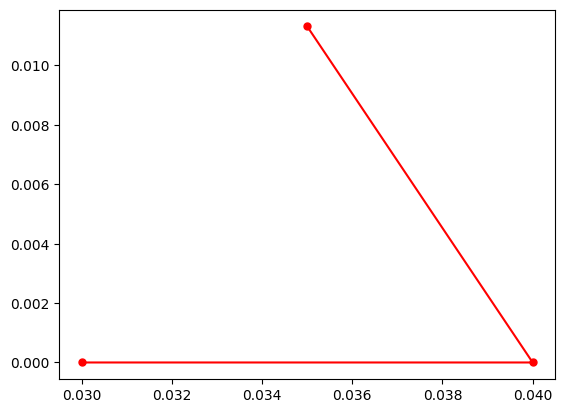

In [16]:
points = mesher.points[mesher.cells[0]]
print(points)
plt.plot(points[:,0], points[:,1], marker='o', color='red', markersize=5, label='Cell Points')
print(mesher.points[mesher.faces[mesher.cell_face_indices[0,2]]])

In [17]:
# Given physical parameters
Re = 100            # Reynolds number
nu = 0.1     # physical kinematic viscosity
L = 100             # domain length (physical units)
dx = 1           # spatial step (physical units)
dt = 0.1            # time step (physical units)

# Speed of sound squared for D2Q9 lattice
c_s_sq = 1.0 / 3.0

# Convert to lattice units
U_lattice = Re * nu / L

# Compute relaxation time tau
Tau = nu / c_s_sq + 0.5

# Print results
print(f"Lid velocity (lattice units): {U_lattice:.5f}")
print(f"Relaxation time tau: {Tau:.5f}")
U_lid = U_lattice
dynamics = D2Q9(tau=Tau,delta_t = dt)

Lid velocity (lattice units): 0.10000
Relaxation time tau: 0.80000


In [18]:
cells,faces,nodes = mesher.to_env(dynamics)
env = Environment(cells,faces,nodes)
env.init()

/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/meshers.py:151: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.n = jnp.array(self.face_normals,dtype=jnp.float64)
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/meshers.py:152: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.L = jnp.array(self.face_lengths,dtype=jnp.float64)[...,jnp.newaxis] * 50
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesh

In [19]:
for i in tqdm(range(100000)):
    env = env.step()

 16%|█▌        | 15512/100000 [00:14<01:18, 1081.43it/s]



KeyboardInterrupt: 

In [ ]:
env = env.step()

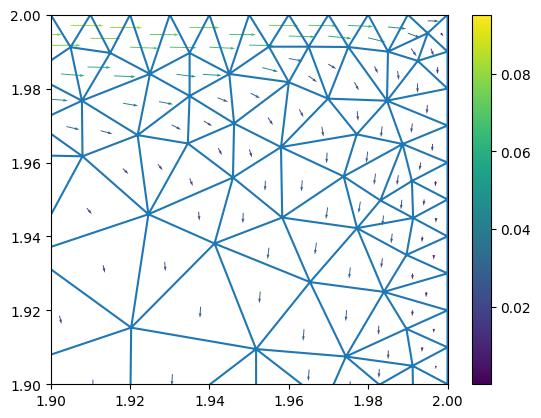

In [20]:
xy = np.array(mesher.cell_centers)
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel 
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.quiver(x,y,vel[:,0],vel[:,1],mag,scale=1)
xy = np.asarray(mesher.points)
x = xy[:,0]
y = xy[:,1]
tri = np.asarray(mesher.cells)
plt.triplot(x,y,tri)
plt.axis([1.9,2,1.9,2])
#plt.axis([-1,-.9,-1,-.9])
plt.colorbar()
plt.show()

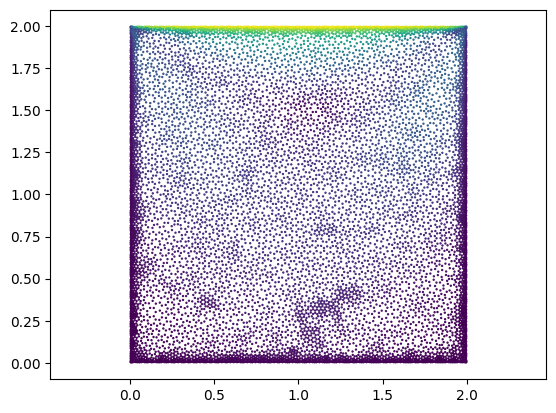

In [27]:
xy = np.array(mesher.cell_centers)
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.scatter(x, y, c=mag, cmap='viridis', vmin=0, vmax=jnp.max(mag), s=0.5, marker='o')
plt.axis('equal')
plt.show()

In [28]:
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(xy, vel)

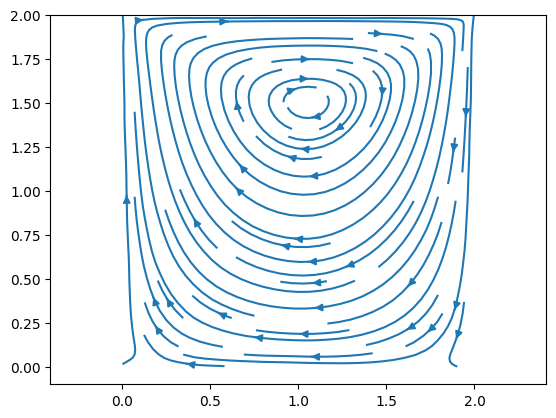

In [36]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.streamplot(x, y, vel[:,:,0], vel[:,:,1],density=1)
plt.axis('equal')
plt.show()

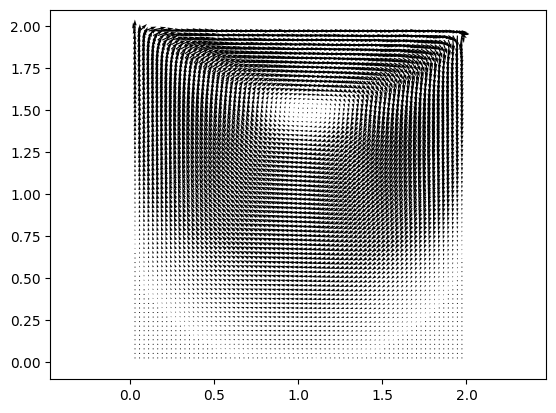

In [31]:
x = np.linspace(0, 2, 75)
y = np.linspace(0, 2, 75)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.quiver(x,y,vel[:,:,0],vel[:,:,1],scale=1)
plt.axis('equal')
plt.show()

In [32]:
from scipy.io import loadmat
ref_data = loadmat('../ref/ldc_Re100.mat')
refu = ref_data['u'].T[...,jnp.newaxis]
refv = ref_data['v'].T[...,jnp.newaxis]
refx = ref_data['x'].squeeze()
refy = ref_data['y'].squeeze()
# x,y = jnp.meshgrid(x,y)
# x = jnp.expand_dims(x.flatten(),axis=-1)
# y = jnp.expand_dims(y.flatten(),axis=-1)
# xy = jnp.concatenate((x,y),axis=-1)
sol = jnp.concatenate((refu,refv),axis=-1)
solx = sol[128,:,1]
soly = sol[:,128,0]

In [33]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
outx = interp(x,np.ones_like(x))[...,1]/U_lid
outy = interp(np.ones_like(y),y)[...,0]/U_lid

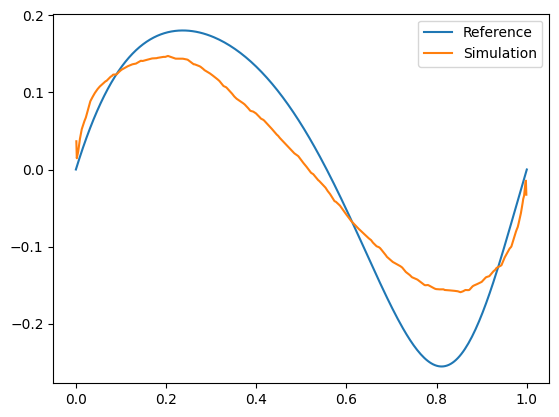

In [34]:
plt.plot(refy,solx)
plt.plot(x/2,outx)
plt.legend(['Reference','Simulation'])
plt.show()

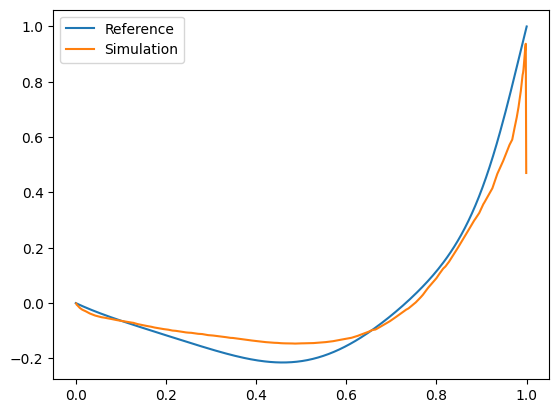

In [35]:
plt.plot(refy,soly)
plt.plot(y/2,outy)
plt.legend(['Reference','Simulation'])
plt.show()

# Tri mesh test


In [55]:
from scipy.io import loadmat
data = loadmat("IRTmesh.mat")

In [56]:
mesher = Mesher()
mesher.points = np.array([data["NODE"][0,i][2][0][:,0] for i in range(data["NODE"].shape[1])], dtype=np.float64)
mesher.cells = np.array([[data["CELL"][0,i][j][0][0][0] for j in range(6,9)] for i in range(data["CELL"].shape[1])],dtype=np.int32)-1
mesher.faces = np.array([[data["FACE"][0,i][j][0][0][0] for j in range(7,9)] for i in range(data["FACE"].shape[1])],dtype=np.int32)-1
mesher.point_markers = np.zeros_like(mesher.points[:,0])

mesher.enforce_ccw()

print(mesher.points.shape, mesher.cells.shape, mesher.faces.shape, mesher.point_markers.shape)

mesher.calc_mesh_properties()

(20201, 2) (40000, 3) (60200, 2) (20201,)
Calculating cell centers...
Cell centers calculated.
Calculating face centers...
Face centers calculated.
Calculating face normals...
Calculating face centers...
Face centers calculated.
Calculating face normals...
Face normals calculated.
Calculating face lengths...
Face normals calculated.
Calculating face lengths...
Face lengths calculated.
Calculating cell face indices and normals...
Face lengths calculated.
Calculating cell face indices and normals...
Cell face indices and normals calculated.
Calculating cell face normal signs...
Cell face normal signs calculated.
Calculating face cell indices...
Cell face indices and normals calculated.
Calculating cell face normal signs...
Cell face normal signs calculated.
Calculating face cell indices...
Face cell indices calculated.
Calculating face ghost distances...
Face ghost distances calculated.
Calculating point cell indices and distances...
Face cell indices calculated.
Calculating face ghost d

In [64]:
mesher.verify_stencil_geometry()

Mean angle (deg): 0.00, max: 0.01
Faces with angle > 30 deg: 0
Mean distance error: 0.0000, max: 0.0000
Faces with distance error > 1e-2: 0


In [57]:
# Given physical parameters
Re = 100            # Reynolds number
nu = 0.1     # physical kinematic viscosity
L = 100             # domain length (physical units)
dx = 1           # spatial step (physical units)
dt = 0.1            # time step (physical units)

# Speed of sound squared for D2Q9 lattice
c_s_sq = 1.0 / 3.0

# Convert to lattice units
U_lattice = Re * nu / L

# Compute relaxation time tau
Tau = nu / c_s_sq + 0.5

# Print results
print(f"Lid velocity (lattice units): {U_lattice:.5f}")
print(f"Relaxation time tau: {Tau:.5f}")
U_lid = U_lattice
dynamics = D2Q9(tau=Tau,delta_t = dt)

Lid velocity (lattice units): 0.10000
Relaxation time tau: 0.80000


Diagonal face index: 1, nodes: [9801    0], other node: 9801
Cell indices on node 9801: [0, 1, 2, 3]
Face 0: Center=[0.015 0.015], Normal=[-0.70710677  0.70710677], Distances=[0.00471405 0.00471405], Point Plus=[0.01166667 0.01833333], Point Minus=[0.01833333 0.01166667]
Face 1: Center=[0.01 0.02], Normal=[-0.  1.], Distances=[0.00333333 0.00333333], Point Plus=[0.01       0.02333333], Point Minus=[0.01       0.01666667]
Face 2: Center=[0.005 0.015], Normal=[-0.70710677 -0.70710677], Distances=[0.00471405 0.00471405], Point Plus=[0.00166667 0.01166667], Point Minus=[0.00833333 0.01833333]
Face 0: Center=[0.015 0.005], Normal=[0.70710677 0.70710677], Distances=[0.00471405 0.00471405], Point Plus=[0.01833333 0.00833333], Point Minus=[0.01166667 0.00166667]
Face 1: Center=[0.02 0.01], Normal=[-1.  0.], Distances=[0.00333333 0.00333333], Point Plus=[0.01666667 0.01      ], Point Minus=[0.02333333 0.01      ]
Face 2: Center=[0.015 0.015], Normal=[-0.70710677  0.70710677], Distances=[0.00471

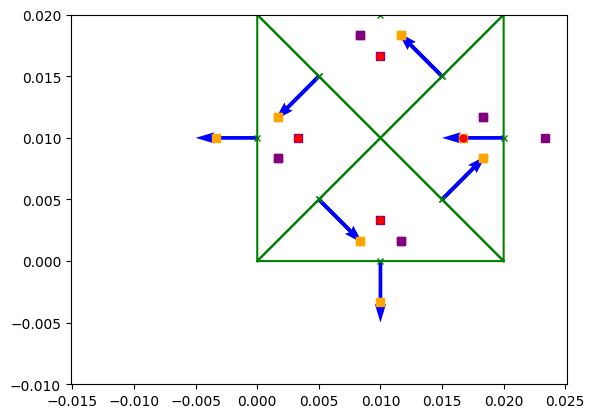

In [58]:
xy = np.asarray(mesher.points)
x = xy[:,0]
y = xy[:,1]
tri = np.asarray(mesher.cells)
# Find the diagonal face attached to corner node 0
corner_node = 0
# Find all faces that include node 0
faces_with_node0 = [i for i, face in enumerate(mesher.faces) if corner_node in face]
# For each such face, check if it is a diagonal (not an edge of the box)
# Here, since the box is axis-aligned, diagonal faces will not have both nodes as box corners
# We'll just pick the first face for demonstration
if faces_with_node0:
    face_idx = faces_with_node0[0]
    face_nodes = mesher.faces[face_idx]
    # The other node attached to the face (not node 0)
    other_node = face_nodes[0] if face_nodes[1] == corner_node else face_nodes[1]
    print(f"Diagonal face index: {face_idx}, nodes: {face_nodes}, other node: {other_node}")

    # Find all cell indices that include this other node
    cells_on_other_node = [i for i, cell in enumerate(mesher.cells) if other_node in cell]
    print(f"Cell indices on node {other_node}: {cells_on_other_node}")
else:
    print("No face found attached to node 0.")
for cell_index in cells_on_other_node:
    face_centers = mesher.face_centers[mesher.cell_face_indices[cell_index]]
    normals = mesher.face_normals[mesher.cell_face_indices[cell_index]] 

    for i, (fc, nrm, dist) in enumerate(zip(face_centers, normals, mesher.face_cell_center_distances[mesher.cell_face_indices[cell_index]])):
        # Point along the normal direction
        pt_plus = fc + nrm * dist[1]
        # Point in the opposite direction
        pt_minus = fc - nrm * dist[0]
        print(f"Face {i}: Center={fc}, Normal={nrm}, Distances={dist}, Point Plus={pt_plus}, Point Minus={pt_minus}")
        plt.plot([pt_plus[0]], [pt_plus[1]], marker='s', color='orange', markersize=6, label='Along Normal' if i == 0 else "")
        plt.plot([pt_minus[0]], [pt_minus[1]], marker='s', color='purple', markersize=6, label='Opposite Normal' if i == 0 else "")

    plt.triplot(x,y,tri[cell_index:cell_index +1],color="g")
    plt.plot(mesher.cell_centers[cell_index,0],mesher.cell_centers[cell_index,1], marker='o', color='red', markersize=5, label='Cell Center')
    plt.plot(face_centers[:,0], face_centers[:,1], marker='x', color='green', markersize=5, label='Face Center',linestyle='None')
    #normals = normals*mesher.cell_face_normal_signs[cell_index,:,jnp.newaxis]
    plt.quiver(face_centers[:,0], face_centers[:,1],normals[:,0], normals[:,1], color='blue', angles='xy', scale_units='xy', scale=200, label='Face Normals')
plt.axis('equal')
plt.axis([-.01, .02, -.01, .02])
#plt.axis([-1,-.9,-1,-.9])
plt.show()

[[0.01 0.01]
 [0.02 0.02]
 [0.   0.02]]
[[0.01 0.01]
 [0.   0.02]]


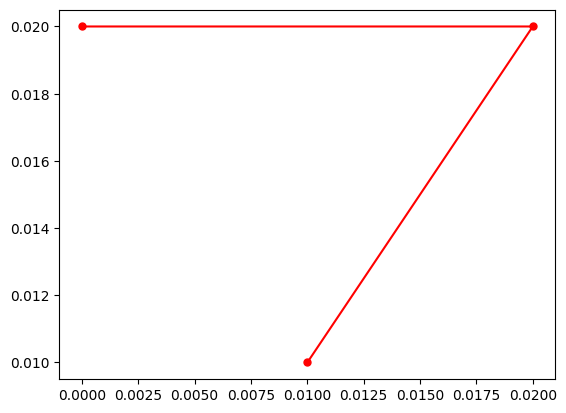

In [59]:
points = mesher.points[mesher.cells[0]]
print(points)
plt.plot(points[:,0], points[:,1], marker='o', color='red', markersize=5, label='Cell Points')
print(mesher.points[mesher.faces[mesher.cell_face_indices[0,2]]])

In [60]:
cells,faces,nodes = mesher.to_env(dynamics)
env = Environment(cells,faces,nodes)
env.init()

/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/meshers.py:151: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.n = jnp.array(self.face_normals,dtype=jnp.float64)
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/meshers.py:152: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  faces.L = jnp.array(self.face_lengths,dtype=jnp.float64)[...,jnp.newaxis] * 50
/Users/sungjepark/Documents/GitHub/FVDBMSolver/tests/../src/mesh

In [61]:
for i in tqdm(range(100000)):
    env = env.step()

  5%|▌         | 5283/100000 [00:19<05:47, 272.28it/s]


KeyboardInterrupt: 

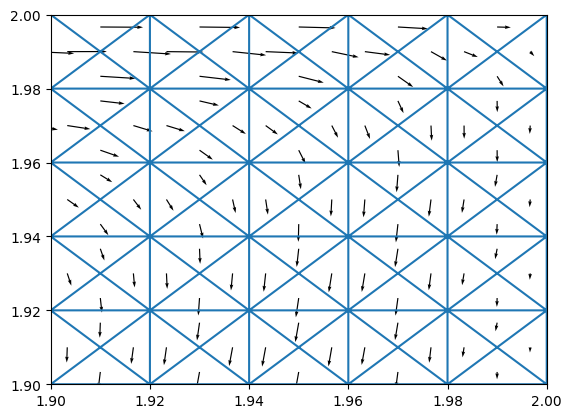

In [62]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel 
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.quiver(x,y,vel[:,0],vel[:,1],scale=1)
plt.axis([0,.1,0,.1])
xy = np.asarray([data["NODE"][0,i][2,0][:,0] for i in range(data["NODE"].size)])
x = xy[:,0]
y = xy[:,1]
tri = np.asarray([data["CELL"][0,i][6:9][:,0] for i in range(data["CELL"].size)])-1
plt.triplot(x,y,tri)
plt.axis([1.9,2,1.9,2])
plt.show()

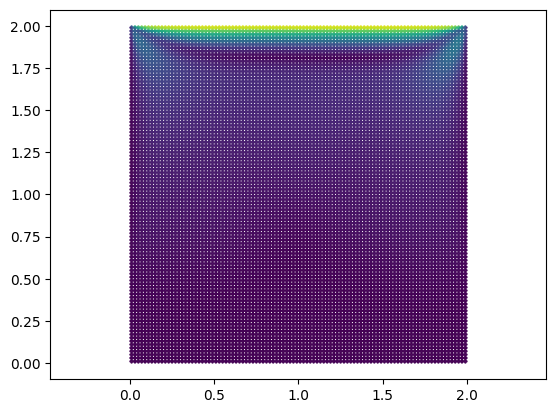

In [63]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.scatter(x,y,c=mag,cmap='viridis',vmin=0,vmax=U_lid,s=.5)
plt.axis('equal')
plt.show()